# Rede Neural Convolucional (32x32 px - 3 camadas (RGB))

Construção de uma Rede Neural Convolucional focado em imagens por 32px quadrados, para obter os tipos baseados em datasets Cifar10.

## Tipos de reconhecimento (baseado em CIFAR10)

- Avião
- Automóvel
- Pássaro
- Gato
- Veado
- Cachorro
- Sapo
- Cavalo
- Barco
- Caminhão

---

# 1 - Imports

- Tensorflow
- Keras
- Numpy
- Matplotlib
- CV2
- Imgaug
- sklearn

In [ ]:
!pip install imgaug
from imgaug import augmenters as iaa
from tensorflow import keras
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten, Dense, MaxPooling2D, Conv2D, Dropout, BatchNormalization, Rescaling
from keras.engine.training import optimizer
from keras.api._v2.keras import callbacks
from sklearn.model_selection import train_test_split
import cv2

---

# 2 - Datasets

O Dataset utilizado foi o **CIFAR10**, utilizado comumente para rede neurais Ccnvolucionais iniciantes, para prática e estudo dessa área de aprendizado de máquina.

## Data Augmentation

Foi utilizado a biblioteca **imgaug** para para criar mais exemplos de imagens, tuilizando a tecnica Data Augmentation, assim facilitando o aumento de acurácia da CNN.

In [14]:
cifar10 = keras.datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [35]:
seq = iaa.Sequential([
    iaa.Fliplr(0.2),
    iaa.Crop(percent=(0, 0.1)),
    iaa.Sometimes(
        0.1,
        iaa.GaussianBlur(sigma=(0, 0.25))
    ),
    iaa.Affine(
        scale={"x": (0.4, 0.6), "y": (0.4, 0.6)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-10, 10),
        shear=(-4, 4)
    )
], random_order=True)

In [34]:
def visualize(image):
  plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.imshow(image)

In [37]:
train_images, x_val, train_labels, y_val = train_test_split(
    train_images, train_labels, test_size=0.2)

In [38]:
for i in range(2):
  train_images = np.vstack( (train_images,
                             seq.augment_images(train_images[:40000])))
  train_labels = np.vstack( (train_labels, train_labels[:40000]))

In [39]:
print(train_images.shape)
print(train_labels.shape)

print(test_images.shape)

(120000, 32, 32, 3)
(120000, 1)
(10000, 32, 32, 3)


---

# 3 - Imagens de exemplo do **CIFAR10**

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


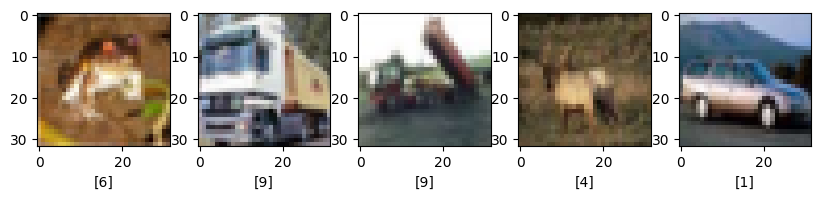

In [33]:
plt.figure(figsize=(10,10))
for i in range(5):
  plt.subplot(5,5,i+1)
  plt.imshow(train_images[i])
  plt.xlabel(train_labels[i])

---

# 4 - Criando Modelo Neural

Foi criado uma rede neural baseado na biblioteca **Keras**, para utilizar padrões mais alto nível.

Também foi criado uma função para "plotar" meus gráficos com mostragem visual do rendimento da minha rede neural baseado em acurácia e perda.

Foi utilizado **Callbacks** para criar **salvar** o modelo, achar o ponto **mínimo de treino** e melhorar os niveis de **Learning Rate** no treinamento. 

In [28]:
def def_model():
  model = keras.Sequential()

  model.add(Rescaling(scale=1.0/255))

  model.add(Conv2D(filters=32, kernel_size=5, padding='same', activation='relu', input_shape=(32,32,3)))
  model.add(MaxPooling2D(pool_size=[2,2], strides=2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=[2,2], strides=2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=128, kernel_size=5, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=[2,2], strides=2))
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.33))
  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.build(input_shape=(None, 32, 32, 3))
  model.summary()

  return model

In [18]:
def plot_history(history, test_images, test_labels, model):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.xlabel('epoch')
  plt.legend(['loss', 'val_loss'], loc='lower left')
  plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.xlabel('epoch')
  plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
  plt.show()

  test_loss, test_acc = model.evaluate(test_images, test_labels)

  print(test_loss)
  print(test_acc)

In [40]:
model = def_model()

callbacksModel = [
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=3, min_lr=0.0001),
    keras.callbacks.ModelCheckpoint(
        save_best_only=True,
        filepath='best_model.h5'
    )
]

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 32, 32, 3)         0         
                                                                 
 conv2d_36 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_36 (Bat  (None, 16, 16, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_37 (Conv2D)          (None, 16, 16, 64)        51264     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 8, 8, 64)       

---

# 5 - Treino CNN

Epoch 1/15
3000/3000 [==============================] - 30s 6ms/step - loss: 1.6232 - accuracy: 0.4146 - val_loss: 1.4609 - val_accuracy: 0.4576 - lr: 0.0010
Epoch 2/15
3000/3000 [==============================] - 18s 6ms/step - loss: 1.2237 - accuracy: 0.5642 - val_loss: 1.2899 - val_accuracy: 0.5399 - lr: 0.0010
Epoch 3/15
3000/3000 [==============================] - 19s 6ms/step - loss: 1.0411 - accuracy: 0.6334 - val_loss: 1.2643 - val_accuracy: 0.5462 - lr: 0.0010
Epoch 4/15
3000/3000 [==============================] - 17s 6ms/step - loss: 0.9082 - accuracy: 0.6804 - val_loss: 1.1573 - val_accuracy: 0.5895 - lr: 0.0010
Epoch 5/15
3000/3000 [==============================] - 19s 6ms/step - loss: 0.7979 - accuracy: 0.7184 - val_loss: 1.0763 - val_accuracy: 0.6185 - lr: 0.0010
Epoch 6/15
3000/3000 [==============================] - 18s 6ms/step - loss: 0.6953 - accuracy: 0.7536 - val_loss: 1.0850 - val_accuracy: 0.6238 - lr: 0.0010
Epoch 7/15
3000/3000 [==============================

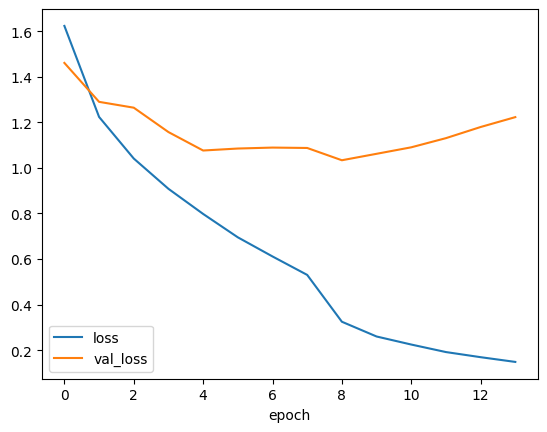

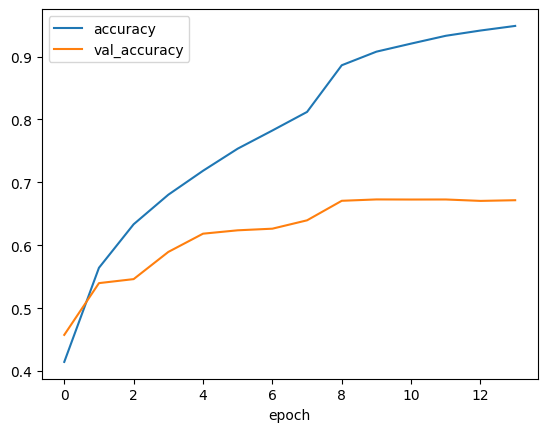

313/313 [==============================] - 2s 4ms/step - loss: 1.1257 - accuracy: 0.7869
1.125698208808899
0.786899983882904


In [41]:
history = model.fit(train_images, train_labels, 
                    epochs=15, validation_split=0.2,
                    callbacks = callbacksModel)

plot_history(history, test_images, test_labels, model)